# Creating Ridge Plots from FlowJo exported Flow Cytometry Histograms

In [82]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline

In [83]:
datfile = '/Users/jkgerdts/Google Drive/LAB/data/2021 05-31 KISRE a3 CD4 coculture/histograms.csv'
data = pd.read_csv(datfile)
data.describe()

,bins,ctrl_ctrl_A,ctrl_ctrl_B,a3_ctrl_A,a3_ctrl_B,ctrl_CD4_A,ctrl_CD4_B,a3_CD4_A,a3_CD4_B
count,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000,4096.000000
mean,25786.883689,4.008301,5.490479,5.440186,5.425537,3.556152,3.772461,4.157715,4.157959
std,52039.902062,6.616879,9.026614,8.711063,8.750584,5.929687,6.181107,8.600056,8.622808
min,-173.393140,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,175.904435,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1735.389352,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,20646.993955,7.000000,10.000000,10.000000,10.000000,6.000000,7.000000,3.000000,3.000000
max,261660.842800,35.000000,49.000000,44.000000,47.000000,38.000000,33.000000,49.000000,46.000000


In [160]:
def hist_smoother(df,squishfactor):

    import pandas as pd
    from pathlib import Path
    import numpy as np
    
    columns = [x for x in df.columns if x not in ['bin','bins']]

    def smooth(x,window_len=11,window='hanning'):
        if x.ndim != 1:
            print('error too many dimensions')
            return None
        if x.size < window_len:
            print('error window len too big')
            return None
        if window_len<3:
            return x
        if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
            print("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
            return None
        s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
        #print(len(s))
        if window == 'flat': #moving average
            w=np.ones(window_len,'d')
        else:
            w=eval('np.'+window+'(window_len)')
        y=np.convolve(w/w.sum(),s,mode='valid')
        return y

    bins_orig = df['bins'].values
    newbins = [bins_orig[i] for i in range(0,len(bins_orig),squishfactor)]
    df['newbins'] = [next((i for i,v in enumerate(newbins) if v>=x), max(newbins)) for x in bins_orig]
    for col in columns:
        s = sum(df[col].values)
        df[col] = [x/s for x in df[col].values]

    dfg = df.groupby('newbins').sum()

    return dfg

def ridge_plot(df,figpath='',populations = [],fs=[5,10],squishfactor=30):
    sns.set_style("white")
    # List of separable colors
    colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', 
          '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
          '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', 
          '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080']
    
    # FlowJo seems to give populations as columns and bins is fluoresence intensities corrected and binned?
    
    df = hist_smoother(df,squishfactor)
    #df = df.set_index("bins")
    df.describe()
    
    if len(populations)<1:
        populations = [col for col in df.columns if col not in ['bins','newbins']]
        # otherwise populations defaults to user input
    rows = len(populations)
    df = df.reset_index()
    
    #print(f"Generating {rows} rows in figure...")
    # Create figure rows based on number of populations
    fig,axs = plt.subplots(rows,1,figsize=fs)

    # NOTE: this could probably be done with a groupby
    # Need to iterate over populations
    for i,pop in enumerate(populations):
        #print(i,pop)
        
        # White line for density to make boundaries pop more
        plot = df[pop].plot(ax=axs[i],color="white", linewidth=2)

        # Fill under graph with different color
        x = plot.get_children()[0]._x
        y = plot.get_children()[0]._y
        axs[i].fill_between(x,y,color=colors[i])

        # Set the background transparent
        axs[i].patch.set_alpha(0)

        # Remove y ticks and y labels
        axs[i].set_yticklabels([])
        axs[i].set_ylabel("")
        # Remove x ticks except for bottom subplot
        if i != rows-1:
            axs[i].set_xticklabels([])

        # Remove all spines    
        spines = ["left","top","right","bottom"]
        for spine in spines:
            axs[i].spines[spine].set_visible(False)
        
        # TODO: I've only been able to adjust this position hardcoded, find solution
        # New Y labels
        axs[i].text(-2,0,pop,fontweight="bold",fontsize=24,ha="right")
        #axs[i].set_xlim(0,1e6)
        
        
    # Overlap subplots
    plt.subplots_adjust(hspace=-0.5)
    
    dfbins = pd.DataFrame({'bins':[1e0,1e1,1e2,1e3,1e4,1e5,1e6]})
    dfbins = dfbins.merge(df.reset_index(),on='bins',how='outer').sort_values('bins').set_index('bins')
    dfbins = dfbins.interpolate()
    tick_loc = dfbins.loc[[1e0,1e1,1e2,1e3,1e4,1e5,1e6],:]['index'].values

    axs[-1].set_xticks(ticks)
    axs[-1].set_xticklabels(['','','','$10^3$','$10^4$','$10^5$','$10^6$'])#
    axs[-1].xaxis.tick_bottom()
    
    if figpath>'':
        plt.savefig(figpath,bbox_inches='tight')
    plt.show()
    
    return df
    
    


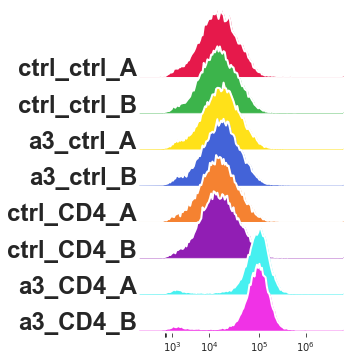

In [161]:
df = ridge_plot(data,figpath='',fs=[4,6],squishfactor=25)
#savefig('/Users/jkgerdts/Google Drive/LAB/data/2021 05 KISRE Fortessa CD8 and agonist/histograms.pdf')


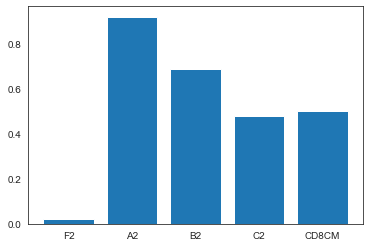

In [31]:
temp = [sum(df[x].iloc[60:])/sum(df[x]) for x in ['F2','A2','B2','C2','CD8CM']]
ax = plt.bar([1,2,3,4,5],temp,tick_label=['F2','A2','B2','C2','CD8CM'])

In [114]:
f.savefig('/Users/jkgerdts/Google Drive/LAB/data/2021 04-22 expression.pdf',bbox_inches='tight')

In [133]:
df.describe()

,newbins,bins,J,PT,PTH,Psgl,Vla,Cd44,PTsortHi,Ptsort,PTHsort,Psglsort,Vlasort,Cd44sort,EphBInew
count,138.000000,1.380000e+02,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000
mean,0.000466,7.635999e+05,0.007246,0.007246,0.007246,0.007246,0.007246,0.007246,0.007246,0.007246,0.007246,0.007246,0.007246,0.007246,0.007246
std,0.005283,1.523779e+06,0.021155,0.010242,0.010691,0.014446,0.009574,0.012490,0.016303,0.013109,0.014845,0.016961,0.011661,0.014446,0.008638
min,0.000000,-2.098688e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000008,4.547746e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000017,4.909374e+04,0.000000,0.001768,0.001104,0.000080,0.002700,0.000514,0.000041,0.000214,0.000084,0.000038,0.000967,0.000076,0.002129
75%,0.000025,6.115091e+05,0.000118,0.011738,0.011506,0.005286,0.010858,0.007945,0.002685,0.006657,0.004243,0.001829,0.008730,0.005363,0.014950
max,0.062077,7.293343e+06,0.103137,0.032453,0.035176,0.056102,0.032947,0.043678,0.065382,0.046645,0.055521,0.068301,0.042767,0.053456,0.027367


In [134]:
results = pd.read_csv('Results.csv')

In [135]:
results.describe()

,,Mean,X,Y,IntDen,Median,RawIntDen,Ch,Frame
count,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.0,116.000000
mean,58.500000,23891.000000,242.964103,273.475586,23891.000000,23891.000000,23891.000000,1.0,1.836207
std,33.630343,22244.146211,136.611860,142.299730,22244.146211,22244.146211,22244.146211,0.0,0.843842
min,1.000000,0.000000,6.167000,12.833000,0.000000,0.000000,0.000000,1.0,1.000000
25%,29.750000,6322.500000,133.833250,155.333500,6322.500000,6322.500000,6322.500000,1.0,1.000000
50%,58.500000,15595.500000,247.166500,278.500000,15595.500000,15595.500000,15595.500000,1.0,2.000000
75%,87.250000,35724.000000,344.167000,398.166750,35724.000000,35724.000000,35724.000000,1.0,3.000000
max,116.000000,65535.000000,500.833000,506.167000,65535.000000,65535.000000,65535.000000,1.0,3.000000


In [137]:
print('x=newArray('+','.join([str(int(x)) for x in results['X']])+');')
print('y=newArray('+','.join([str(int(x)) for x in results['Y']])+');')
print('t=newArray('+','.join([str(int(x)) for x in results['Frame']])+');')

x=newArray(38,16,24,74,146,135,152,211,216,234,267,329,371,358,280,258,252,331,318,323,394,380,421,418,417,448,429,427,481,490,486,392,328,282,264,231,196,157,116,65,15,126,150,108,217,224,241,223,218,281,421,294,16,35,46,117,6,105,109,162,212,195,238,265,306,294,344,377,388,401,321,500,376,487,318,300,213,151,163,180,327,328,306,138,74,6,12,55,104,91,59,53,62,128,116,40,37,184,173,234,200,288,268,258,261,378,344,380,407,500,493,411,346,323,301,146);
y=newArray(76,133,201,235,210,51,45,122,111,94,75,93,122,134,206,210,221,297,304,293,260,224,232,200,185,156,64,22,344,341,397,354,383,400,378,356,374,454,443,417,289,297,301,277,456,454,452,468,494,478,456,438,60,134,289,363,350,499,484,490,489,432,309,266,279,316,263,319,304,433,506,433,496,295,79,63,65,150,176,202,45,29,156,12,96,74,171,208,198,222,251,265,272,312,381,424,437,416,485,484,353,290,196,144,53,73,249,259,152,100,221,343,453,470,471,281);
t=newArray(1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,

In [143]:
rgb = pd.read_csv('temp_RGB.csv')

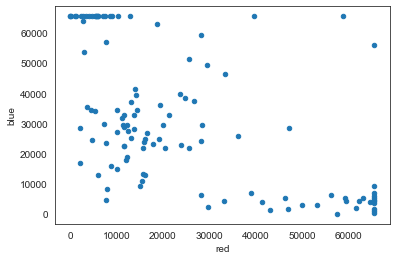

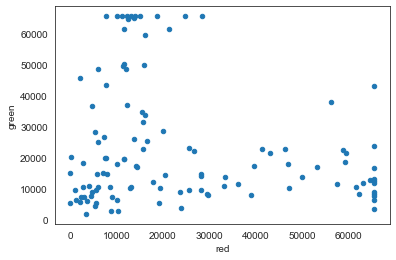

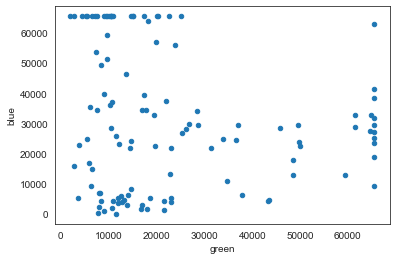

In [144]:
rgb.plot.scatter('red','blue')
rgb.plot.scatter('red','green')
rgb.plot.scatter('green','blue')

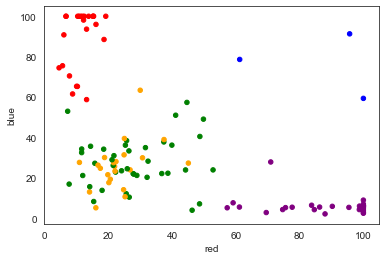

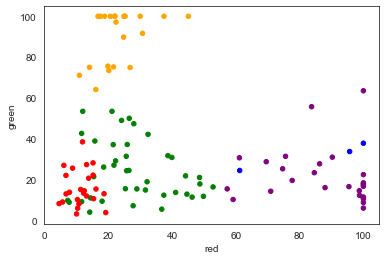

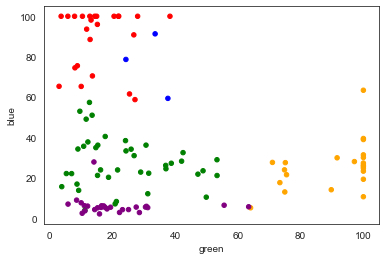

In [166]:
import numpy as np
from sklearn.cluster import KMeans

rgb = pd.read_csv('temp_rgb.csv');
def normalize(arr):
    qnt = np.quantile(arr,0.9)
    arr = [min([100,x/qnt*100]) for x in arr]
    return arr
for color in ['red','green','blue']:
    rgb[color]=normalize(rgb[color])
    
kmeans = KMeans(n_clusters=5, random_state=0).fit(rgb)
rgb['kmeans']=kmeans.labels_

cmap={1:'purple',2:'green',3:'orange',4:'blue',0:'red'}
rgb.plot.scatter('red','blue',c=rgb['kmeans'].map(cmap))
rgb.plot.scatter('red','green',c=rgb['kmeans'].map(cmap))
rgb.plot.scatter('green','blue',c=rgb['kmeans'].map(cmap))


In [156]:
rgb

,red,green,blue,kmeans
0,11.969883,68.896645,7.231250,2
1,21.586217,100.000000,49.837491,2
2,100.000000,12.983263,10.357824,0
3,46.469284,12.692948,3.712520,0
4,11.297664,42.433569,45.603113,3
...,...,...,...,...
111,40.281423,15.223289,78.306249,1
112,6.253673,17.203141,100.000000,4
113,3.832744,11.882288,100.000000,4
114,13.853350,4.346791,24.429694,3


In [40]:
cumsum =lambda arr: [sum(arr[:i+1]) for i in range(len(arr))]

In [50]:
from numpy import random
randsum=lambda ln: cumsum([random.randn() for i in range(ln)])

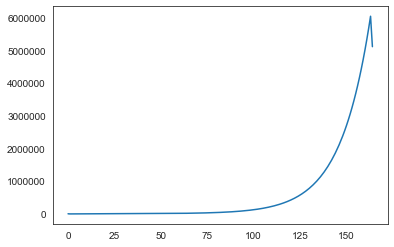

In [88]:
df.bins.plot()

In [80]:
[10**x for x in range(0,4,0.1)]


TypeError: 'float' object cannot be interpreted as an integer

In [89]:
df

,newbins,bins,ctrl_ctrl_A,ctrl_ctrl_B,a3_ctrl_A,a3_ctrl_B,ctrl_CD4_A,ctrl_CD4_B,a3_CD4_A,a3_CD4_B
0,0.0000,-1.733931e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0000,-4.195217e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0000,-3.933117e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0000,-3.679835e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0000,-3.434661e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
160,160.0000,5.014662e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
161,161.0000,5.336140e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162,162.0000,5.678245e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
163,163.0000,6.042299e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
df.reset_index()

,index,newbins,bins,ctrl_ctrl_A,ctrl_ctrl_B,a3_ctrl_A,a3_ctrl_B,ctrl_CD4_A,ctrl_CD4_B,a3_CD4_A,a3_CD4_B
0,0,0.0000,-1.733931e+02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,1.0000,-4.195217e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2.0000,-3.933117e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,3.0000,-3.679835e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,4.0000,-3.434661e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
160,160,160.0000,5.014662e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
161,161,161.0000,5.336140e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162,162,162.0000,5.678245e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
163,163,163.0000,6.042299e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


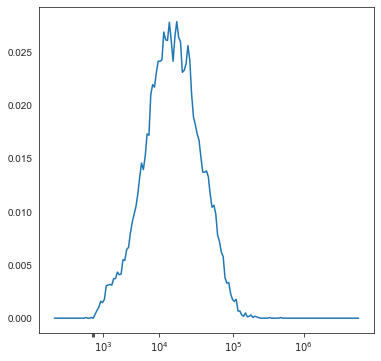

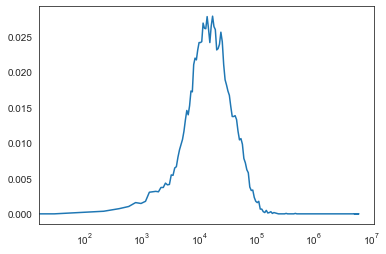

In [152]:
plt.semilogx(df['bins'],df['ctrl_ctrl_A'])
#plt.xscale('log')
ax.xaxis.tick_bottom()